# LSTM vs. Transformers for Stock Price Prediction

> Question: Build a model to predict stock prices for the next 5 years

We will evaluate our model on several axis: First, prediction performance on the test data set. Second, the variance of our model predictions over the variance of the underlying test data. T

Evaluation Metrics:

For prediction performance: Mean Absolute Percentage Error (MAPE).
Specific implementation here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_percentage_error.html

For uncertainty: np.var('our predictions') / np.var('actual data')

For speed: seconds of runtime.
Specific implementation: https://docs.python.org/3/library/timeit.html

Implementation steps:

1. Set up our helper classes (`ETL`, `PredictAndForecast`, `Evaluate`). ✅
2. Implement an LSTM as a baseline.✅
3. rain our model and use them for inference, measuring performance as we go.✅
4. Evaluate our models' performances against our test set. ✅
5. Visualize our predictions as a sanity check.✅
6. Made predictions for the next 5 years and visualised the predictions✅

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras import layers
import tensorflow as tf
import time
import timeit

## 1. Helper Classes

In [2]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """
    def __init__(self, ticker, test_size=0.2, period='max', n_input=5, timestep=5) -> None:
        self.ticker = ticker
        self.period = period
        self.test_size = test_size
        self.n_input = n_input
        self.df = self.extract_historic_data()
        self.timestep = timestep
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

    def extract_historic_data(self) -> pd.Series:
        """
        gets historical data from yf api.
        """
        t = yf.Ticker(self.ticker)
        history = t.history(period=self.period)
        return history.Close

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        data = self.extract_historic_data()
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        return result.reshape((samples, self.timestep, NUM_FEATURES))

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        return np.array(X), np.array(y)

In [3]:
class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """
    def __init__(self, model, train, test, n_input=5) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)

        # Check if data has enough dimensions
        if data.ndim < 3:
            data = data.reshape((data.shape[0], 1, data.shape[1]))

        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))

        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]

        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))

        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)

        # we only want the vector forecast
        yhat = yhat[0]

        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        return np.array(predictions)


In [4]:
class Evaluate:

  def __init__(self, actual, predictions) -> None:
    self.actual = actual
    self.predictions = predictions
    self.var_ratio = self.compare_var()
    self.mape = self.evaluate_model_with_mape()

  def compare_var(self):
    return abs( 1 - (np.var(self.predictions) / np.var(self.actual)))

  def evaluate_model_with_mape(self):
    return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

In [5]:
data = ETL('NVDA')

## 2. Implementing an LSTM baseline

In [6]:
def build_lstm(etl: ETL, epochs=28, batch_size=32) -> tf.keras.Model:
  """
  Builds, compiles, and fits our LSTM baseline model.
  """
  n_timesteps, n_features, n_outputs = 5, 1, 5
  callbacks = [tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
  model = Sequential()
  model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
  model.add(Dense(50, activation='relu'))
  model.add(Dense(n_outputs))
  print('compiling baseline model...')
  model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mape'])
  print('fitting model...')
  start = time.time()
  history = model.fit(etl.X_train, etl.y_train, batch_size=batch_size, epochs=epochs, validation_data=(etl.X_test, etl.y_test), verbose=1, callbacks=callbacks)
  print(time.time() - start)
  return model, history

In [7]:
baseline = build_lstm(data)

compiling baseline model...
fitting model...
Epoch 1/28
157/157 [==============================] - 9s 14ms/step - loss: 16.6831 - mae: 1.2676 - mape: 23.5839 - val_loss: 225.8971 - val_mae: 9.4836 - val_mape: 5.2469
Epoch 2/28
157/157 [==============================] - 2s 15ms/step - loss: 1.1498 - mae: 0.4451 - mape: 8.0508 - val_loss: 393.1606 - val_mae: 13.2628 - val_mape: 7.1665
Epoch 3/28
157/157 [==============================] - 3s 22ms/step - loss: 1.3370 - mae: 0.4821 - mape: 7.9787 - val_loss: 386.6400 - val_mae: 12.6962 - val_mape: 6.7030
Epoch 4/28
157/157 [==============================] - 2s 12ms/step - loss: 1.0996 - mae: 0.4377 - mape: 7.2534 - val_loss: 204.6250 - val_mae: 9.0025 - val_mape: 4.9917
Epoch 5/28
157/157 [==============================] - 2s 12ms/step - loss: 1.0275 - mae: 0.4154 - mape: 6.9602 - val_loss: 309.5496 - val_mae: 11.4078 - val_mape: 6.0244
Epoch 6/28
157/157 [==============================] - 2s 13ms/step - loss: 1.1539 - mae: 0.4608 - mape: 7

In [8]:
baseline_model = baseline[0]
history = baseline[1]

In [9]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense (Dense)               (None, 50)                10050     
                                                                 
 dense_1 (Dense)             (None, 5)                 255       
                                                                 
Total params: 171905 (671.50 KB)
Trainable params: 171905 (671.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Inference on our Models

In [10]:
start = time.time()
baseline_preds = PredictAndForecast(baseline_model, data.train, data.test)
print(time.time() - start)

21.2950119972229


# 4. Evaluating on test set

In [11]:
baseline_evals = Evaluate(data.test, baseline_preds.predictions)

In [12]:
baseline_evals.mape

0.043288987604490695

In [13]:
baseline_evals.var_ratio

0.05704853291424472

# 5. Visualizing

In [14]:
def plot_results(test, preds, df, image_path=None, title_suffix=None, xlabel='NVIDA stock Price'):
  """
  Plots training data in blue, actual values in red, and predictions in green,
  over time.
  """
  fig, ax = plt.subplots(figsize=(20,6))
  # x = df.Close[-498:].index
  plot_test = test[1:]
  plot_preds = preds[1:]
  x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
  plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
  ax.plot(x, plot_test, label='actual')
  ax.plot(x, plot_preds, label='preds')
  if title_suffix==None:
    ax.set_title('Predictions vs. Actual')
  else:
    ax.set_title(f'Predictions vs. Actual, {title_suffix}')
  ax.set_xlabel('Date')
  ax.set_ylabel(xlabel)
  ax.legend()
  if image_path != None:
    imagedir = '/content/drive/MyDrive/Colab Notebooks/images'
    plt.savefig(f'{imagedir}/{image_path}.png')
  plt.show()

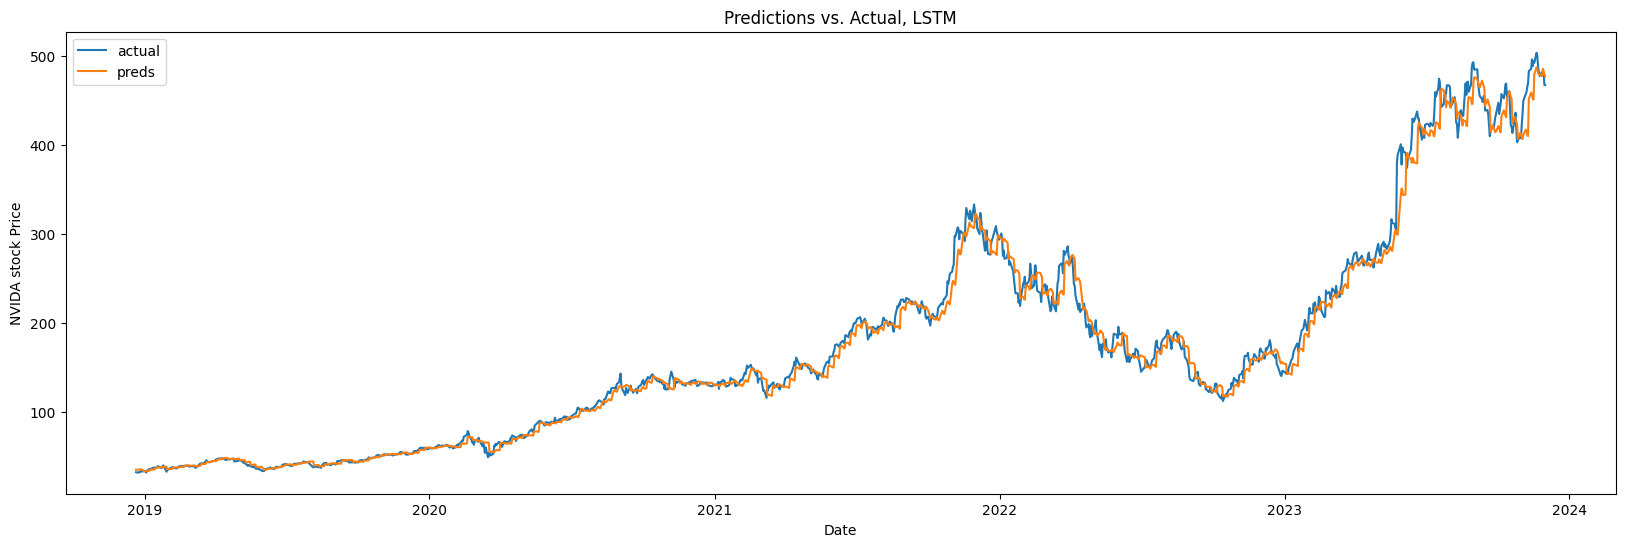

In [15]:
plot_results(data.test, baseline_preds.predictions, data.df, title_suffix='LSTM')

In [16]:
# Save the model to a file path
model_save_path = 'Stock_price_predictor_model.h5'
baseline_model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: Stock_price_predictor_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
# Function to make future predictions
def make_future_predictions(model, etl, num_years=5):
    # Initialize a PredictAndForecast instance
    forecast_instance = PredictAndForecast(model, etl.train, etl.test)

    # Make future predictions for each week in the future
    future_predictions = []
    for _ in range(num_years * 52):  # Assuming 52 weeks in a year
        # Make a prediction for the next week
        next_week_prediction = forecast_instance.forecast(etl.test[-1, :, :])

        # Append the prediction to the list
        future_predictions.append(next_week_prediction)

        # Update the test set with the new prediction for the next iteration
        etl.test = np.vstack([etl.test[1:, :], next_week_prediction.reshape((1, etl.test.shape[1], etl.test.shape[2]))])

    return np.array(future_predictions)

# Load your existing model and ETL instance
baseline_model = tf.keras.models.load_model('Stock_price_predictor_model.h5')
data = ETL('NVDA')

# Make future predictions for the years 2024 to 2028
future_predictions = make_future_predictions(baseline_model, data, num_years=5)

# Print or use the future predictions as needed
print(future_predictions)



[[463.8443   471.4824   468.81506  465.22348  463.1441  ]
 [455.78555  463.21915  460.8761   456.92523  455.08008 ]
 [447.9017   455.18616  452.8911   449.00235  447.20514 ]
 ...
 [ 68.951065  69.026405  69.308556  68.91741   68.84553 ]
 [ 68.90628   68.98117   69.263596  68.87292   68.80152 ]
 [ 68.862854  68.937294  69.21998   68.82976   68.75883 ]]


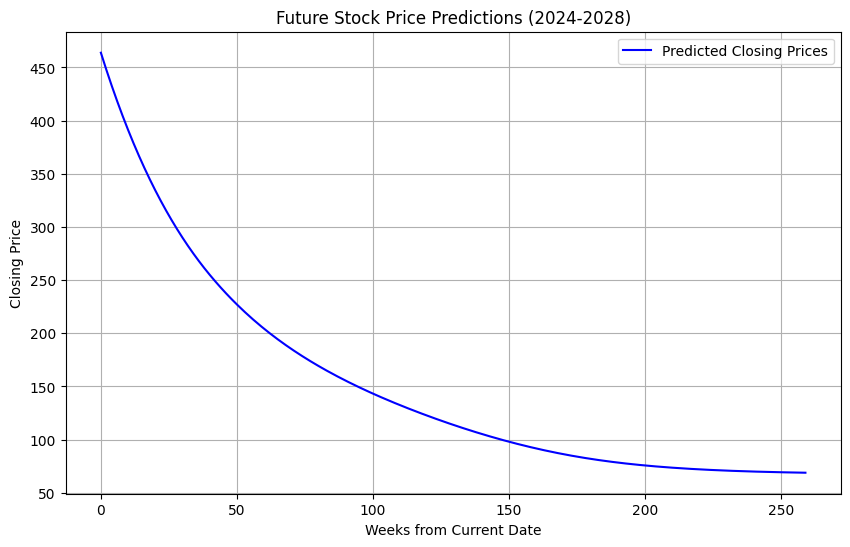

In [18]:
# Assuming your future_predictions array has a shape of (num_weeks, num_features)
# You may need to adjust the indices based on the structure of your predictions

# Extract the predicted closing prices (assuming it's the first feature)
predicted_closing_prices = future_predictions[:, 0]

# Generate the corresponding timeline for the future predictions
timeline = range(len(predicted_closing_prices))

# Plot the predicted closing prices
plt.figure(figsize=(10, 6))
plt.plot(timeline, predicted_closing_prices, label='Predicted Closing Prices', color='blue')

# Add labels and title
plt.xlabel('Weeks from Current Date')
plt.ylabel('Closing Price')
plt.title('Future Stock Price Predictions (2024-2028)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
